In [1]:
# innstall java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

# set your spark folder to your system path environment. 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"

# install findspark using pip
!pip install -q findspark

In [3]:
import pandas as pd
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [19]:
from google.colab import files
files.upload()

Saving Ecom.csv to Ecom (1).csv


{'Ecom.csv': b'\xef\xbb\xbfEmail,Avatar,AvgSessionLength,Time on App,Time on Website,Length of Membership,Yearly Amount Spent\r\nmstephenson@fernandez.com,Violet,34.49726773,12.65565115,39.57766802,4.082620633,587.951054\r\nhduke@hotmail.com,DarkGreen,31.92627203,11.10946073,37.26895887,2.664034182,392.2049334\r\npallen@yahoo.com,Bisque,33.00091476,11.33027806,37.11059744,4.104543202,487.5475049\r\nriverarebecca@gmail.com,SaddleBrown,34.30555663,13.71751367,36.72128268,3.120178783,581.852344\r\nmstephens@davidson-herman.com,MediumAquaMarine,33.33067252,12.79518855,37.5366533,4.446308318,599.406092\r\nalvareznancy@lucas.biz,FloralWhite,33.87103788,12.02692534,34.47687763,5.493507201,637.1024479\r\nkatherine20@yahoo.com,DarkSlateBlue,32.0215955,11.36634831,36.68377615,4.685017247,521.5721748\r\nawatkins@yahoo.com,Aqua,32.73914294,12.35195897,37.37335886,4.434273435,549.9041461\r\nvchurch@walter-martinez.com,Salmon,33.9877729,13.38623528,37.53449734,3.273433578,570.200409\r\nbonnie69@lin.

In [83]:
data = spark.read.csv('Ecom (1).csv',inferSchema=True, header=True)

In [84]:
data.show(10)

+--------------------+----------------+----------------+-----------+---------------+--------------------+-------------------+
|               Email|          Avatar|AvgSessionLength|Time on App|Time on Website|Length of Membership|Yearly Amount Spent|
+--------------------+----------------+----------------+-----------+---------------+--------------------+-------------------+
|mstephenson@ferna...|          Violet|     34.49726773|12.65565115|    39.57766802|         4.082620633|         587.951054|
|   hduke@hotmail.com|       DarkGreen|     31.92627203|11.10946073|    37.26895887|         2.664034182|        392.2049334|
|    pallen@yahoo.com|          Bisque|     33.00091476|11.33027806|    37.11059744|         4.104543202|        487.5475049|
|riverarebecca@gma...|     SaddleBrown|     34.30555663|13.71751367|    36.72128268|         3.120178783|         581.852344|
|mstephens@davidso...|MediumAquaMarine|     33.33067252|12.79518855|     37.5366533|         4.446308318|         599.

In [22]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [85]:
for i in data.columns:
    print(i+':',data[data[i].isNull()].count())

Email: 0
Avatar: 0
AvgSessionLength: 0
Time on App: 0
Time on Website: 0
Length of Membership: 0
Yearly Amount Spent: 0


In [86]:
assembler = VectorAssembler(inputCols=["AvgSessionLength",'Time on App','Time on Website','Length of Membership'],outputCol='features')

In [87]:
data1 = assembler.transform(data)

In [56]:
regdata = data1.select("features","Yearly Amount Spent")

In [27]:
from sklearn.model_selection import train_test_split

In [57]:
train_data, test_data = regdata.randomSplit([0.7, 0.3])

In [34]:
from pyspark.ml.regression import LinearRegression

In [58]:
models = LinearRegression(featuresCol='features',labelCol='Yearly Amount Spent')
Ecommodel = models.fit(train_data)

summary = Ecommodel.summary

print('\033[1m' + 'RMSE:',summary.rootMeanSquaredError)
print('R2 score:', summary.r2)
print('MAE score:', summary.meanAbsoluteError)
print('MSE score:', summary.meanSquaredError)

RMSE: 9.927882577793559
R2 score: 0.9841341038995979
MAE score: 7.831573045460302
MSE score: 98.56285247845688


In [48]:
predictions = Ecommodel.transform(test_data)

# Display the predictions
predictions.show(20)

+--------------------+-------------------+------------------+
|            features|Yearly Amount Spent|        prediction|
+--------------------+-------------------+------------------+
|[31.04722214,11.1...|        392.4973992| 388.1387198138782|
|[31.26810421,12.1...|        423.4705332| 426.7198720383508|
|[31.57413802,12.9...|        544.4092722| 558.9719350283212|
|[31.6005122,12.22...|        479.1728515|460.86649529726674|
|[31.60983957,12.7...|        444.5455497|426.77850731433887|
|[31.6739155,12.32...|        475.7250679|  502.222570578293|
|[31.7207699,11.75...|        538.7749335| 546.6248712672343|
|[31.72420252,13.1...|        503.3878873|509.26641272604525|
|[31.82797906,12.4...|        440.0027475| 449.0674139949663|
|[31.87455169,10.2...|        392.2852442|397.83360451146905|
|[31.90485713,12.2...|        473.9498574| 491.0650915834656|
|[31.90962683,11.3...|        563.4460357| 552.2513844251907|
|[31.92627203,11.1...|        392.2049334| 379.8614349862346|
|[31.945

In [39]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(predictionCol='prediction',
                                labelCol='Yearly Amount Spent',
                                metricName='r2')

print('\033[1m' + 'R2 on the test data:',evaluator.evaluate(predictions)) 

R2 on the test data: 0.9849447505414364


In [50]:
Ecommodeltest = models.fit(test_data)

# Get summary of the model
summary = Ecommodeltest.summary

# Print RMSE , R2 , MAE , MSE
print('\033[1m' + 'RMSE:',summary.rootMeanSquaredError)
print('R2 score:', summary.r2)
print('MAE score:', summary.meanAbsoluteError)
print('MSE score:', summary.meanSquaredError)

RMSE: 10.407071627351064
R2 score: 0.9838750390586901
MAE score: 8.218182951919905
MSE score: 108.30713985681551


In [60]:

import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


+-----------------------------+-----------------------------+
|skewness(Yearly Amount Spent)|kurtosis(Yearly Amount Spent)|
+-----------------------------+-----------------------------+
|          0.03468572636729024|           0.4473727018192597|
+-----------------------------+-----------------------------+



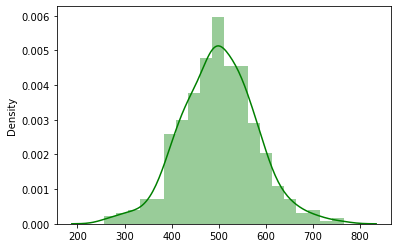

In [61]:
sns.distplot(data.select('Yearly Amount Spent').toPandas(), color="green")
data.select(F.skewness('Yearly Amount Spent'), F.kurtosis('Yearly Amount Spent')).show()

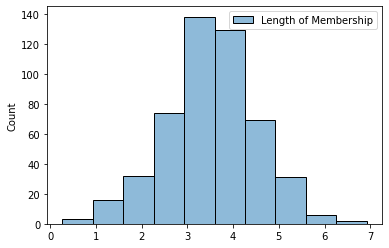

In [63]:
sns.histplot(data.select('Length of Membership').toPandas(), bins = 10)

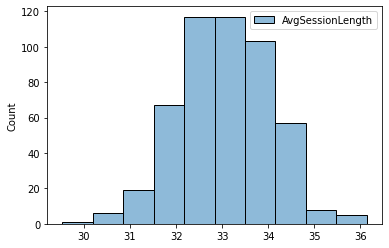

In [64]:
sns.histplot(data.select('AvgSessionLength').toPandas(), bins = 10)

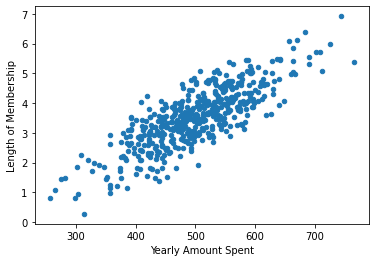

In [78]:
  data.plot.scatter(x='Yearly Amount Spent', y='Length of Membership') 